# part0: imports

In [13]:
import os, sys, pathlib
from pprint import pprint 
from importlib import reload
import logging
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.simplefilter("ignore")


import pandas as pd
import numpy as np
import xarray as xr
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator


from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal

%matplotlib inline

root= pathlib.Path("/data")

# Compare similar target in 2 animals

In [40]:
animalList = ['Chewie', 'Mihili']

animalFiles={}
for animal in animalList:
    animalFiles[animal] = utility.find_file(root / animal,'mat')

# just keeping the CS sessions
goodFiles = [file for animal in animalFiles for file in animalFiles[animal] if 'CS' in file]
pprint(goodFiles)

# keeping 1 session per animal
fileList = ['/data/Chewie/Chewie_CO_CS_2016-10-14.mat', '/data/Mihili/Mihili_CO_VR_2014-03-03.mat']

['/data/Chewie/Chewie_CO_CS_2016-10-14.mat',
 '/data/Chewie/Chewie_CO_CS_2016-10-21.mat',
 '/data/Mihili/Mihili_CO_CS_2015-05-12.mat',
 '/data/Mihili/Mihili_CO_CS_2015-05-11.mat',
 '/data/Mihili/Mihili_CO_CS_2014-06-26.mat',
 '/data/Mihili/Mihili_CO_CS_2014-06-27.mat',
 '/data/Mihili/Mihili_CO_CS_2014-09-29.mat',
 '/data/Mihili/Mihili_CO_CS_2014-12-03.mat']


In [41]:
df_data=[]
for fname in fileList:
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)
    df_data.append(df)


all the preprocessing steps

In [42]:
def prep_pyalData (df):
    df_= pyal.add_firing_rates(df, 'smooth')
    df_= pyal.select_trials(df_, df_.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    df_= pyal.select_trials(df_, df_.target_direction < -2)
    # quickfix for the buf in indexing:
    df_['idx_movement_on'] = np.int64(df_.idx_movement_on)
    
    df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
    df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
    
    df_ = pyal.restrict_to_interval(df_, start_point_name='idx_movement_on', rel_start=0, rel_end=30)
    
    M1_rates = np.concatenate(df_.M1_rates.values, axis=0)
    pca_model = PCA(n_components=20, svd_solver='full');
    pca_model.fit(M1_rates);
    df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'M1_rates', 'M1_pca');

    PMd_rates = np.concatenate(df_.PMd_rates.values, axis=0)
    pca_model = PCA(n_components=20, svd_solver='full');
    pca_model.fit(PMd_rates);
    df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'PMd_rates', 'PMd_pca');

    
    return df_

Prep both sessions

In [43]:
df_data_ = [prep_pyalData(df) for  df in df_data]

plot the CCs across animals, all targets combined

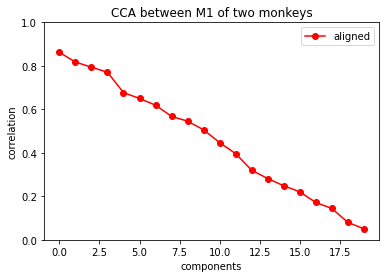

In [44]:
d0_M1 = np.concatenate(df_data_[0].M1_pca.values, axis=0)
d1_M1 = np.concatenate(df_data_[1].M1_pca.values, axis=0)

# same number of timepoints in both matrices
n_samples_M1 = min ([d0_M1.shape[0], d1_M1.shape[0]])
d0_M1_ = d0_M1[:n_samples_M1,:]
d1_M1_ = d1_M1[:n_samples_M1,:]

CC_M1 = dt.canoncorr(d0_M1_, d1_M1_)

_,ax = plt.subplots()

ax.plot(CC_M1, 'r-o', label='aligned')

ax.set_xlabel('components')
ax.set_ylabel('correlation')
ax.legend()
ax.set_ylim([0,1])
ax.set_title('CCA between M1 of two monkeys');

#### BE WARE!

results depend on the initial number of PCs, i.e., features in the data matrix.
For 10 PCs, the max CC will be 0.75 instead of 0.85

---
Next, let's add to the plot above, within monkey M1 CCs.

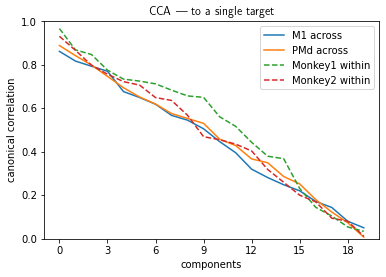

In [45]:
d0_PMd = np.concatenate(df_data_[0].PMd_pca.values, axis=0)
d1_PMd = np.concatenate(df_data_[1].PMd_pca.values, axis=0)

# same number of timepoints in both matrices
n_samples_d0 = min ([d0_M1.shape[0], d0_PMd.shape[0]])
n_samples_d1 = min ([d1_M1.shape[0], d1_PMd.shape[0]])
d0_PMd_ = d0_PMd[:n_samples_d0,:]
d1_PMd_ = d1_PMd[:n_samples_d1,:]
n_samples_PMd = min ([d0_PMd.shape[0], d1_PMd.shape[0]])
d0_PMd_ = d0_PMd[:n_samples_PMd,:]
d1_PMd_ = d1_PMd[:n_samples_PMd,:]



CC_d0 = dt.canoncorr(d0_M1_, d0_PMd_)
CC_d1 = dt.canoncorr(d1_M1_, d1_PMd_)
CC_PMd= dt.canoncorr(d0_PMd_, d1_PMd_)

_,ax = plt.subplots()

ax.plot(CC_M1, label='M1 across')
ax.plot(CC_PMd, label='PMd across')
ax.plot(CC_d0,'--', label='Monkey1 within')
ax.plot(CC_d1,'--', label='Monkey2 within')

ax.set_xlabel('components')
ax.set_ylabel('canonical correlation')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('CCA --- to a single target', usetex=True);

average over every target

In [46]:
def prep_pyalData_all_targets (df):
    df_= pyal.add_firing_rates(df, 'smooth')
    df_= pyal.select_trials(df_, df_.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    #df_= pyal.select_trials(df_, df_.target_direction < -2)
    # quickfix for the buf in indexing:
    df_['idx_movement_on'] = np.int64(df_.idx_movement_on)
    
    df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
    df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
    
    df_ = pyal.restrict_to_interval(df_, start_point_name='idx_movement_on', rel_start=0, rel_end=30)
    
    M1_rates = np.concatenate(df_.M1_rates.values, axis=0)
    pca_model = PCA(n_components=20, svd_solver='full');
    pca_model.fit(M1_rates);
    df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'M1_rates', 'M1_pca');

    PMd_rates = np.concatenate(df_.PMd_rates.values, axis=0)
    pca_model = PCA(n_components=20, svd_solver='full');
    pca_model.fit(PMd_rates);
    df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'PMd_rates', 'PMd_pca');

    
    return df_


df_data__ = [prep_pyalData_all_targets(df) for  df in df_data]